The comparision between TF-IDF with Logistic Regression, SVM and Random Forest part:


Logistic Regression Evaluation:
              precision    recall  f1-score   support

     Fiction       0.98      0.98      0.98       500
 Non-fiction       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



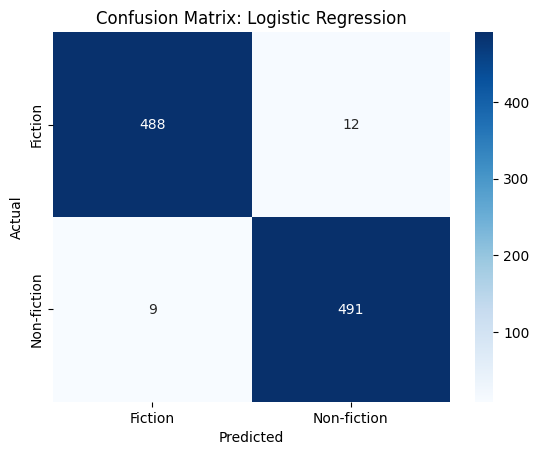


SVM Evaluation:
              precision    recall  f1-score   support

     Fiction       0.98      0.99      0.98       500
 Non-fiction       0.99      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



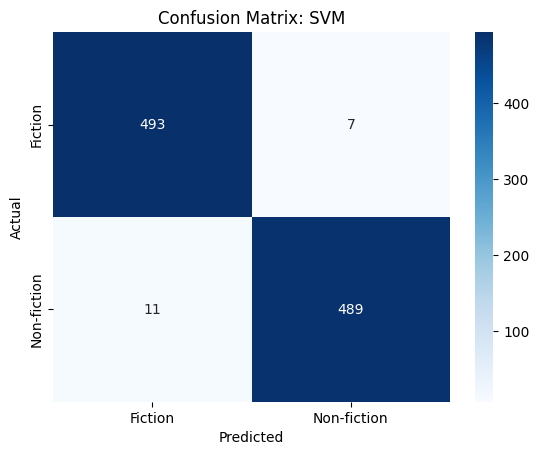


Random Forest Evaluation:
              precision    recall  f1-score   support

     Fiction       0.97      0.97      0.97       500
 Non-fiction       0.97      0.97      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



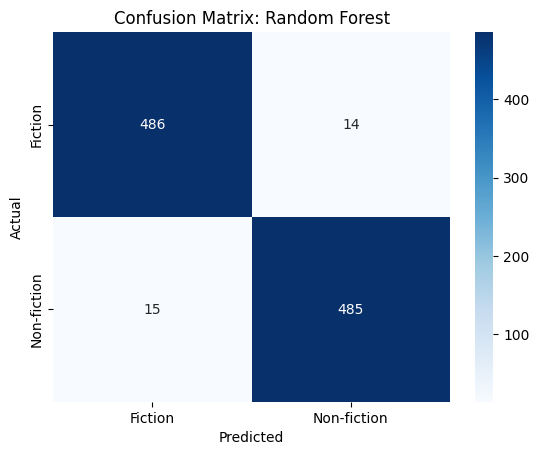


Summary of Model Performance:
                 Model  Accuracy  Precision  Recall     F1
0  Logistic Regression     0.979   0.979017   0.979  0.979
1                  SVM     0.982   0.982031   0.982  0.982
2        Random Forest     0.971   0.971002   0.971  0.971


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('wikipedia_books_dataset.csv')
df['label'] = df['Category'].map({'Fiction': 0, 'Non-fiction': 1})

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(df['Summary'], df['label'], test_size=0.1, stratify=df['label'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1111, stratify=y_train_val, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Model definitions
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=250, min_samples_leaf=5)
}

# Function to evaluate and display results
def evaluate_model(name, model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(f"\n{name} Evaluation:")
    print(classification_report(y_val, y_pred, target_names=['Fiction', 'Non-fiction']))

    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fiction', 'Non-fiction'], yticklabels=['Fiction', 'Non-fiction'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return {
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred, average='macro'),
        'Recall': recall_score(y_val, y_pred, average='macro'),
        'F1': f1_score(y_val, y_pred, average='macro')
    }

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    metrics = evaluate_model(name, model, X_val_tfidf, y_val)
    results.append(metrics)

# Create result table
results_df = pd.DataFrame(results)
print("\nSummary of Model Performance:")
print(results_df)


Try to fine-tune a BERT using hugging face transformer:

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from datasets import Dataset
import pandas as pd
import numpy as np
import evaluate

# Load dataset
df = pd.read_csv("wikipedia_books_dataset.csv")
df['label'] = df['Category'].map({'Fiction': 0, 'Non-fiction': 1})

# Split into train/val/test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Summary'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
val_dataset = Dataset.from_dict({"text": val_texts.tolist(), "label": val_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

# Load tokenizer and preprocess
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(preprocess, batched=True)
val_dataset = val_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="macro")["f1"]
    }

# Training arguments for CPU
training_args = TrainingArguments(
    output_dir="./bert-gpu-output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
     logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

# Train and evaluate
trainer.train()
results = trainer.evaluate(test_dataset)
print("Test Results:", results)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Ziyi Wang\AppData\Local\Temp\ipykernel_54376\3379637225.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ziyiwan (ziyiwan-university-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.086900,0.044215,0.989000,0.988999
2,0.020200,0.057079,0.990000,0.990000


Test Results: {'eval_loss': 0.022973960265517235, 'eval_accuracy': 0.994, 'eval_f1': 0.993999975999904, 'eval_runtime': 4.0634, 'eval_samples_per_second': 246.099, 'eval_steps_per_second': 15.504, 'epoch': 2.0}


Some hard cases to test the model

In [3]:
test_summaries = [
    # Fiction that feels like nonfiction
    "The novel recounts the life of a soldier during World War I, including realistic battle scenes, letters home, and historical context that blurs the line between memoir and fiction.",
    
    # Non-fiction with a storytelling narrative
    "This book explores the early life of Nikola Tesla, using dramatized conversations and reconstructed scenes to depict his inventive mind and childhood struggles.",
    
    # Autobiographical fiction
    "A coming-of-age story that follows the author’s youth in rural America, told in the form of a fictional narrative with heavy autobiographical influence.",
    
    # Narrative non-fiction
    "This gripping account of the 1996 Mount Everest disaster reads like a thriller, following climbers as they battle altitude, ego, and the elements.",
    
    # Fictionalized biography
    "A fictional account of Leonardo da Vinci’s life that weaves real historical facts with imagined motivations, personal conversations, and inner thoughts."
]

In [4]:
from transformers import TextClassificationPipeline
import torch

model.config.id2label = {0: 'Fiction', 1: 'Non-fiction'}

# Create classification pipeline
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    top_k=None  # replaces deprecated `return_all_scores=True`
)

# Predict and print correctly mapped results
for summary in test_summaries:
    results = pipe(summary)[0]  # get the scores for both classes
    sorted_results = sorted(results, key=lambda x: x['score'], reverse=True)
    top = sorted_results[0]
    second = sorted_results[1]
    print(f"\nSummary: {summary[:100]}...")
    print(f"Prediction: {top['label']} | {top['label']} Score: {top['score']:.4f}, {second['label']} Score: {second['score']:.4f}")

Device set to use cuda:0



Summary: The novel recounts the life of a soldier during World War I, including realistic battle scenes, lett...
Prediction: Fiction | Fiction Score: 0.9392, Non-fiction Score: 0.0608

Summary: This book explores the early life of Nikola Tesla, using dramatized conversations and reconstructed ...
Prediction: Non-fiction | Non-fiction Score: 0.9974, Fiction Score: 0.0026

Summary: A coming-of-age story that follows the author’s youth in rural America, told in the form of a fictio...
Prediction: Fiction | Fiction Score: 0.9987, Non-fiction Score: 0.0013

Summary: This gripping account of the 1996 Mount Everest disaster reads like a thriller, following climbers a...
Prediction: Non-fiction | Non-fiction Score: 0.9772, Fiction Score: 0.0228

Summary: A fictional account of Leonardo da Vinci’s life that weaves real historical facts with imagined moti...
Prediction: Fiction | Fiction Score: 0.8790, Non-fiction Score: 0.1210
